In [1]:
from a2c_agent import A2CAgent
import torch
import torch.nn as nn

config = {
    "criticstack": [
        nn.Linear(625, 100),
        nn.ReLU(),
        nn.Linear(100, 25),
        nn.ReLU(),
        nn.Linear(25, 1),
    ],
    "actorstack": [
        nn.Linear(625, 100),
        nn.ReLU(),
        nn.Linear(100, 25),
        nn.ReLU(),
        nn.Linear(25, 4),
        nn.Softmax(dim=0),
    ],
    "inputsize": 625,
    "jointlay": 1,
    "actorhead": [nn.Linear(25, 4)],
    "critichead": [nn.Linear(25, 1)],
    "stack": [nn.Linear(625, 100), nn.ReLU(), nn.Linear(100, 25), nn.ReLU()],
    "epsisodes": 1000,
    "discountfactor": 0.99,
    "t_max": 100,
}

agent = A2CAgent(config, "James")

agent.train()

(tensor([0.1010, 0.1052, 0.1043, 0.1794], grad_fn=<ViewBackward0>), tensor([0.1202], grad_fn=<ViewBackward0>))
<bound method Module.parameters of NeuralNetwork(
  (linearstack): Sequential(
    (0): Linear(in_features=625, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=25, bias=True)
    (3): ReLU()
  )
  (actorstack): Sequential(
    (0): Linear(in_features=25, out_features=4, bias=True)
  )
  (criticstack): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
  )
)>
<bound method Module.parameters of NeuralNetwork(
  (linearstack): Sequential(
    (0): Linear(in_features=625, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=25, bias=True)
    (3): ReLU()
  )
  (actorstack): Sequential(
    (0): Linear(in_features=25, out_features=4, bias=True)
  )
  (criticstack): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
  )
)>
(tensor([0.1010, 0.1052, 0.1043, 0.1794],

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import math
import numpy as np
import matplotlib.pyplot as plt


X_tr = np.load("./kmnist/kmnist-train-imgs.npz")["arr_0"]
y_tr = np.load("./kmnist/kmnist-train-labels.npz")["arr_0"]
X_te = np.load("./kmnist/kmnist-test-imgs.npz")["arr_0"]
y_te = np.load("./kmnist/kmnist-test-labels.npz")["arr_0"]

# Normalize and reshape
X_tr = X_tr.astype(np.float32) / 255.0
X_te = X_te.astype(np.float32) / 255.0
X_tr = np.expand_dims(X_tr, axis=1)  # Add channel dimension
X_te = np.expand_dims(X_te, axis=1)

# Convert to torch tensors
X_tr = torch.tensor(X_tr)
y_tr = torch.tensor(y_tr, dtype=torch.long)
X_te = torch.tensor(X_te)
y_te = torch.tensor(y_te, dtype=torch.long)


# Create train/val split
train_size = int(0.8 * len(X_tr))
val_size = len(X_tr) - train_size
train_dataset, val_dataset = random_split(
    TensorDataset(X_tr, y_tr), [train_size, val_size]
)
test_dataset = TensorDataset(X_te, y_te)

# Data loaders
batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


class ConvNet(nn.Module):
    def __init__(self, filters, hidden_size):
        super().__init__()
        assert len(filters) == 3

        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, filters[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(filters[1], filters[2], kernel_size=3, padding=1)
        # dim_in = math.floor(((dim_out - 1 * (2 - 1) - 1) / 2) + 1) # max pool
        # dim_out = dim_in
        self.fc1 = nn.Linear(self._compute_conv_output_size(), hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 10)

    def _compute_conv_output_size(self):
        x = torch.randn(1, 1, 28, 28)
        x = self.conv1(x)
        # x = self.pool(x)
        x = self.conv2(x)
        # x = self.pool(x)
        x = self.conv3(x)
        # x = self.pool(x)
        return x.size(1) * x.size(2) * x.size(3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.pool(x)
        x = F.relu(self.conv2(x))
        # x = self.pool(x)
        x = F.relu(self.conv3(x))
        # x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.output(x))
        return x


# Training and evaluation functions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(model):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-8)
    criterion = nn.CrossEntropyLoss()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()


def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = output.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

Training with hidden units: 32, Epoch: 1


/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_68059/3789858585.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


Training with hidden units: 32, Epoch: 2
Training with hidden units: 32, Epoch: 3
Training with hidden units: 32, Epoch: 4
Training with hidden units: 32, Epoch: 5
Training with hidden units: 32, Epoch: 6
Training with hidden units: 32, Epoch: 7
Training with hidden units: 32, Epoch: 8
Training with hidden units: 32, Epoch: 9
Training with hidden units: 32, Epoch: 10


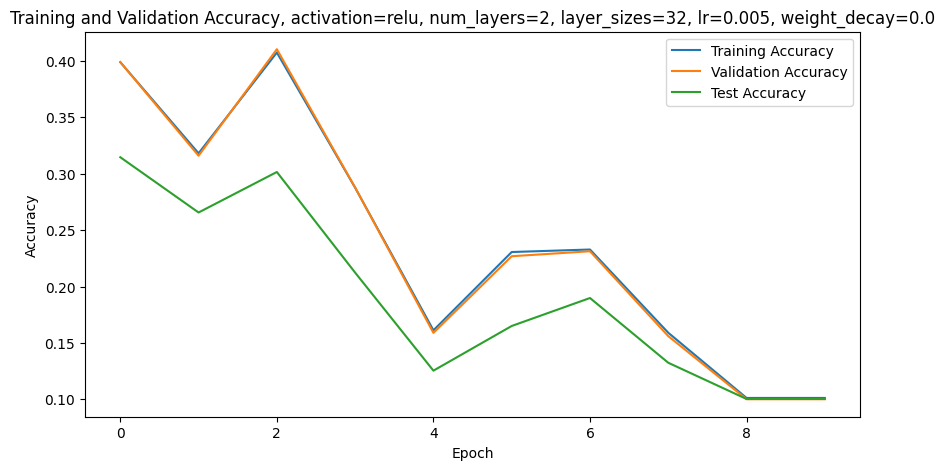

Hidden units: 32, Validation Accuracy: 0.10008333333333333%
Training with hidden units: 64, Epoch: 1
Training with hidden units: 64, Epoch: 2
Training with hidden units: 64, Epoch: 3
Training with hidden units: 64, Epoch: 4
Training with hidden units: 64, Epoch: 5
Training with hidden units: 64, Epoch: 6
Training with hidden units: 64, Epoch: 7
Training with hidden units: 64, Epoch: 8
Training with hidden units: 64, Epoch: 9
Training with hidden units: 64, Epoch: 10


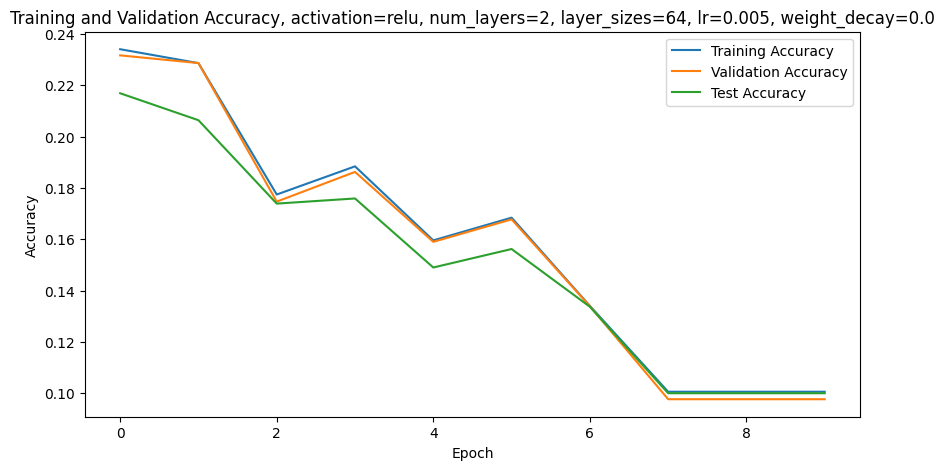

Hidden units: 64, Validation Accuracy: 0.09766666666666667%
Training with hidden units: 128, Epoch: 1
Training with hidden units: 128, Epoch: 2
Training with hidden units: 128, Epoch: 3
Training with hidden units: 128, Epoch: 4
Training with hidden units: 128, Epoch: 5
Training with hidden units: 128, Epoch: 6
Training with hidden units: 128, Epoch: 7
Training with hidden units: 128, Epoch: 8
Training with hidden units: 128, Epoch: 9
Training with hidden units: 128, Epoch: 10


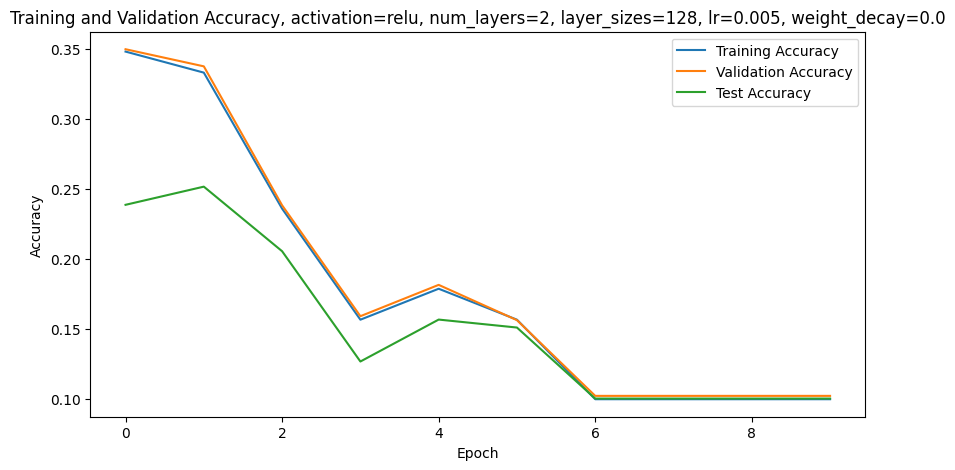

Hidden units: 128, Validation Accuracy: 0.10191666666666667%
Training with hidden units: 256, Epoch: 1
Training with hidden units: 256, Epoch: 2
Training with hidden units: 256, Epoch: 3
Training with hidden units: 256, Epoch: 4
Training with hidden units: 256, Epoch: 5
Training with hidden units: 256, Epoch: 6
Training with hidden units: 256, Epoch: 7
Training with hidden units: 256, Epoch: 8
Training with hidden units: 256, Epoch: 9
Training with hidden units: 256, Epoch: 10


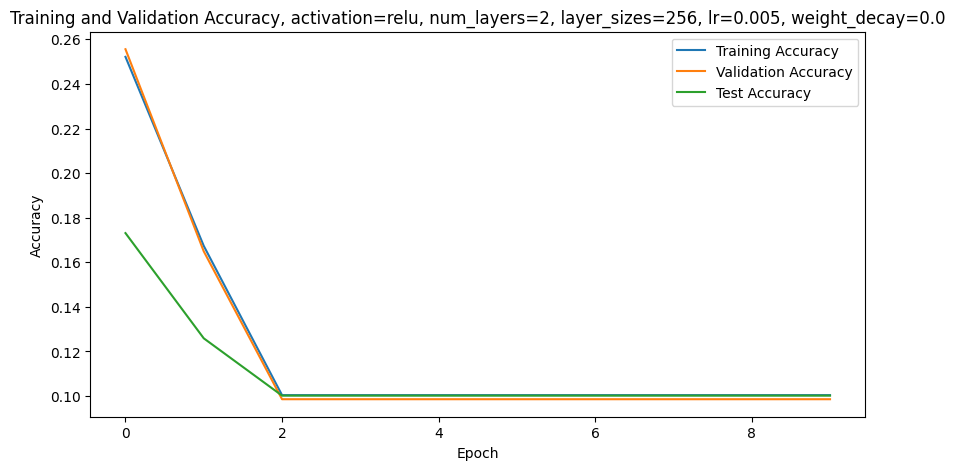

Hidden units: 256, Validation Accuracy: 0.09858333333333333%


: 

In [ ]:
hidden_units_list = [32, 64, 128, 256]
best_acc = 0
best_hidden_units = 0
best_model = None

for hidden_units in hidden_units_list:
    model = ConvNet([32, 64, 128], hidden_units).to(device)
    train_acc = []
    val_acc = []
    test_acc = []
    for epoch in range(10):  # 5 epochs per trial
        print(f"Training with hidden units: {hidden_units}, Epoch: {epoch + 1}")
        train(model)
        train_acc.append(evaluate(model, train_loader))
        val_acc.append(evaluate(model, val_loader))
        test_acc.append(evaluate(model, test_loader))

    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.title(
        f"Training and Validation Accuracy, activation=relu, num_layers=2, layer_sizes={hidden_units}, lr=0.005, weight_decay=0.0"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    val_acc = evaluate(model, val_loader)
    print(f"Hidden units: {hidden_units}, Validation Accuracy: {val_acc}%")
    if val_acc > best_acc:
        best_acc = val_acc
        best_hidden_units = hidden_units
        best_model = model